In [4]:
%load_ext autoreload
%autoreload 2

import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained('lmsys/vicuna-7b-v1.5')
model = AutoModelForCausalLM.from_pretrained(
    'THUDM/cogvlm-grounding-generalist-hf',
    torch_dtype=torch.bfloat16,
    # low_cpu_mem_usage=True,
    trust_remote_code=True,
    cache_dir='/scratch/gsk6me/huggingface_cache'
).to('cuda').eval()


Loading checkpoint shards: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


In [37]:
# chat example
query = 'Q: Enumerate the blue blocks in this image. Provide your answer as a bulleted list with coordinates.'
image = Image.open('./image_blocks.png').convert('RGB')
# image.thumbnail((490,490))
# image = Image.open(requests.get('https://github.com/THUDM/CogVLM/blob/main/examples/1.png?raw=true').raw).convert('RGB')
inputs = model.build_conversation_input_ids(tokenizer, query=query, history=[], images=[image])  # chat mode
inputs = {
    'input_ids': inputs['input_ids'].unsqueeze(0).to('cuda'),
    'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to('cuda'),
    'attention_mask': inputs['attention_mask'].unsqueeze(0).to('cuda'),
    'images': [[inputs['images'][0].to('cuda').to(torch.bfloat16)]],
}
gen_kwargs = {"max_length": 2048, "do_sample": False}

with torch.no_grad():
    outputs = model.generate(**inputs, **gen_kwargs)
    outputs = outputs[:, inputs['input_ids'].shape[1]:]
    print(tokenizer.decode(outputs[0]))

Find the blue blocks [[612,618,698,771]]. Check the place that it on, got the place [[000,000,998,997]]. The blocks [[612,618,698,771]] are on the table. [[000,000,998,997]] So the answer is table.</s>


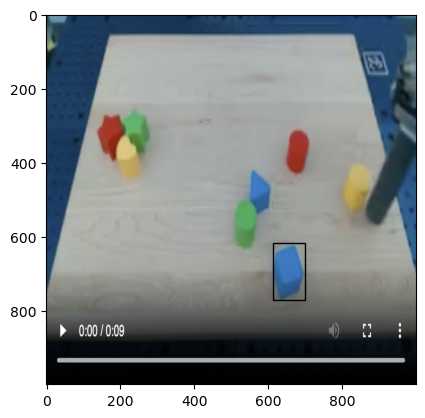

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# xyxy = [136,255,281,458]
# xyxy = [506,419,706,775]
# xyxy = [506,419,710,775]
xyxy = [612,618,698,771]
# xyxy = [544,418,608,540]
x = (xyxy[0])# + xyxy[2]) / 2
y = (xyxy[1])# + xyxy[3]) / 2
w = (xyxy[2] - xyxy[0]) # / 2
h = (xyxy[3] - xyxy[1]) # / 2

plt.imshow(image.resize((1000, 1000)))
plt.gca().add_patch(mpatches.Rectangle((x, y), w, h, fill=False))
plt.show()
